# Cardtonic Twitter Sentiment Analysis 2

In [2]:
# Import basic libries for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
# Import More libries/modules
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords   
from datetime import datetime
import glob                     
import os
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anelawrence/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
df = pd.read_csv('/home/anelawrence/cardtonic_data/cardtonic_tweets.csv')

In [41]:
df_2 = pd.read_csv('/home/anelawrence/cardtonic_data/cardtonic_tweets_2.csv')

In [51]:
# Combine both DataFrame
tweets_df = pd.concat([df, df_2], ignore_index=True)

In [52]:
len(tweets_df)

22670

In [53]:
tweets_df.head()

,id,url,fullText,createdAt,retweetCount,replyCount,likeCount,quoteCount,viewCount,inReplyToUsername,author/followers,author/following,author/userName
0,1897773467732222000,https://x.com/Frowler_/status/1897773467732222077,@cardtonic Real Sociedad 0-1 Manchester United,2025-03-06 22:17,0,0,0,0,34.0,cardtonic,76,486,Frowler_
1,1897759840388121000,https://x.com/Ese_Obox/status/1897759840388120996,@cardtonic ATM 1-0 Real Madrid,2025-03-06 21:22,0,0,0,0,5.0,cardtonic,74,545,Ese_Obox
2,1897757255799353900,https://x.com/tundabam/status/1897757255799353779,@cardtonic Athletic Madrid 0 vs Real Madrid 1,2025-03-06 21:12,0,0,0,0,7.0,cardtonic,340,4328,tundabam
3,1897724028606943200,https://x.com/Adesewa16169371/status/1897724028606943279,@cardtonic ATM 2-2 Real Madrid,2025-03-06 19:00,0,0,0,0,3.0,cardtonic,126,2004,Adesewa16169371
4,1897717740393165000,https://x.com/spghaddaf/status/1897717740393164976,@cardtonic ATM 1-1 R. MADRID,2025-03-06 18:35,0,0,0,0,5.0,cardtonic,618,754,spghaddaf


In [54]:
tweets_df.dtypes

id                     int64
url                   object
fullText              object
createdAt             object
retweetCount           int64
replyCount             int64
likeCount              int64
quoteCount             int64
viewCount            float64
inReplyToUsername     object
author/followers       int64
author/following       int64
author/userName       object
dtype: object

## Data Cleaning

In [55]:
tweets_df["createdAt"] = pd.to_datetime(tweets_df["createdAt"])

# #set index = date so as to create rolling mean 
# tweets_df = tweets_df.sort_values("date").set_index("date")

In [56]:
tweets_df.dtypes

id                            int64
url                          object
fullText                     object
createdAt            datetime64[ns]
retweetCount                  int64
replyCount                    int64
likeCount                     int64
quoteCount                    int64
viewCount                   float64
inReplyToUsername            object
author/followers              int64
author/following              int64
author/userName              object
dtype: object

In [57]:
# check for duplicate tweets
tweets_df['fullText'].duplicated().sum()

7895

In [58]:
# Drop duplicate tweets
tweets_df.drop_duplicates(subset=['fullText'], inplace=True)
tweets_df['fullText'].duplicated().sum()

0

In [59]:
tweets_df.shape

(14775, 13)

In [60]:
# rename fullText to tweet
tweets_df.rename(columns = {'fullText':'tweet'}, inplace = True)

In [61]:
# rename createdAt to date
tweets_df.rename(columns = {'createdAt':'date'}, inplace = True)

In [62]:
tweets_df.columns

Index(['id', 'url', 'tweet', 'date', 'retweetCount', 'replyCount', 'likeCount',
       'quoteCount', 'viewCount', 'inReplyToUsername', 'author/followers',
       'author/following', 'author/userName'],
      dtype='object')

In [63]:
tweets_df = tweets_df[tweets_df['author/userName'] != 'cardtonic']

In [64]:
tweets_df.shape

(11912, 13)

In [65]:
tweets_df.to_csv('/home/anelawrence/cardtonic_data/clean_tweets.csv', index=False)

In [67]:
tweets_df = pd.read_csv('/home/anelawrence/cardtonic_data/clean_tweets.csv')

In [68]:
tweets_df.tweet.head()

0    @cardtonic Real Sociedad 0-1 Manchester United
1                    @cardtonic ATM 1-0 Real Madrid
2     @cardtonic Athletic Madrid 0 vs Real Madrid 1
3                    @cardtonic ATM 2-2 Real Madrid
4                      @cardtonic ATM 1-1 R. MADRID
Name: tweet, dtype: object

In [69]:
# Removing Some football Prediction tweets
# List of keywords to filter out
keywords = ['Real Madrid', 'ATM', 'Manchester United', 'Manchester city', 'Man city', 'Arsenal', 'Tottenham']

# Create a regex pattern that matches any of the keywords (case insensitive)
pattern = '|'.join(keywords)  #'Real Madrid | ATM | Manchester United'

tweets_df = tweets_df[~tweets_df['tweet'].str.contains(pattern, case=False, na=False)].reset_index(drop=True)

In [70]:
tweets_df.tweet.head()

0    @symplyDAPO @cardtonic Let your face shine upon me🙌🏼🙌🏼🙌🏼
1          @Mc_Phils @symplyDAPO @cardtonic Na me be number 2
2                    @Mc_Phils @symplyDAPO @cardtonic Leggooo
3                             @symplyDAPO @cardtonic Leggoooo
4              @Mc_Phils @symplyDAPO @cardtonic Pick me as #1
Name: tweet, dtype: object

In [71]:
tweets_df["date"] = pd.to_datetime(tweets_df["date"])
tweets_df.dtypes

id                            int64
url                          object
tweet                        object
date                 datetime64[ns]
retweetCount                  int64
replyCount                    int64
likeCount                     int64
quoteCount                    int64
viewCount                   float64
inReplyToUsername            object
author/followers              int64
author/following              int64
author/userName              object
dtype: object

In [72]:
# function to clean tweet column
def clean_text(text):  
    pat1 = r'@[^ ]+'                   #@signs
    pat2 = r'https?://[A-Za-z0-9./]+'  #links
    pat3 = r'\'s'                      #floating s's
    pat4 = r'\#\w+'                     # hashtags
    pat5 = r'&amp '
    pat6 = r'[^A-Za-z\s]'         #remove non-alphabet
    pat7 = r'\n'
    combined_pat = r'|'.join((pat1, pat2,pat3,pat4,pat5, pat6, pat7))
    text = re.sub(combined_pat,"",text).lower()
    return text.strip()

In [73]:
tweets_df["tweet"] = tweets_df["tweet"].apply(clean_text)

In [74]:
tweets_df["tweet"].head()

0    let your face shine upon me
1                na me be number
2                        leggooo
3                       leggoooo
4                     pick me as
Name: tweet, dtype: object

## Data Preprocessing

In [3]:
# Load tokenizer and model for the sentiment analysis
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Define our two target labels: negative and positive
labels = ["negative", "positive"]

def predict_sentiment(text):
    # Encode the text
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    # Get the logits (output scores)
    scores = outputs.logits.detach().numpy()[0]
    # Compute exponentials for only negative (index 0) and positive (index 2)
    neg_exp = np.exp(scores[0])
    pos_exp = np.exp(scores[2])
    # Normalize to obtain probabilities for the two classes
    total = neg_exp + pos_exp
    neg_prob = neg_exp / total
    pos_prob = pos_exp / total
    # Select the label with the higher probability
    if neg_prob > pos_prob:
        return pd.Series([labels[0], neg_prob])
    else:
        return pd.Series([labels[1], pos_prob])


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [15]:
# Apply the prediction function to the DataFrame
tweets_df[['sentiment', 'confidence']] = tweets_df['tweet'].apply(predict_sentiment)

In [16]:
tweets_df[['sentiment', 'confidence','tweet']].head(10)

,sentiment,confidence,tweet
0,positive,0.994399,let your face shine upon me
1,positive,0.547732,na me be number
2,negative,0.670869,leggooo
3,negative,0.725139,leggoooo
4,positive,0.552927,pick me as
5,positive,0.997239,god bless you abundantly sir
6,positive,0.825968,i will pick also
7,positive,0.996893,cardtonic is great
8,positive,0.992452,stay blessed
9,positive,0.979980,wowamazing


In [17]:
# Drop columns 'Subjectivity', 'Polarity' and 'Sentiment'
# tweets_df.drop(['Subjectivity', 'Polarity'], axis=1, inplace=True)
tweets_df.columns

Index(['id', 'url', 'tweet', 'date', 'retweetCount', 'replyCount', 'likeCount',
       'quoteCount', 'viewCount', 'inReplyToUsername', 'author/followers',
       'author/following', 'author/userName', 'sentiment', 'confidence'],
      dtype='object')

In [105]:
#creating a polarity column to show if the tweet is positive, negative or neutral (1,-1,0)
def analysis(score):
    if score == "negative":
        return -1
    else:
        return 1

tweets_df['polarity'] = tweets_df['sentiment'].apply(analysis)

In [106]:
tweets_df[['sentiment', 'confidence','tweet', 'polarity']].head()

,sentiment,confidence,tweet,polarity
0,positive,0.994399,let your face shine upon me,1
1,positive,0.547732,na me be number,1
2,positive,0.670869,leggooo,1
3,positive,0.725139,leggoooo,1
4,positive,0.552927,pick me as,1


In [21]:
# tweets_df.to_csv('/home/anelawrence/cardtonic_data/analyzed_tweets_2.csv', index=False)

In [26]:
# Count positive values
positive_count = (tweets_df['sentiment'] == 'positive').sum()

# Count negative values
negative_count = (tweets_df['sentiment'] == 'negative').sum()

# Total number of values
total_count = tweets_df['sentiment'].count()

# Calculate percentages
positive_percentage = (positive_count / total_count) * 100
negative_percentage = (negative_count / total_count) * 100

print(f"Positive Count: {positive_count}, Positive Percentage: {positive_percentage:.2f}%")
print(f"Negative Count: {negative_count}, Negative Percentage: {negative_percentage:.2f}%")


Positive Count: 6537, Positive Percentage: 59.63%
Negative Count: 4426, Negative Percentage: 40.37%


In [28]:
negative_tweets = tweets_df[tweets_df['sentiment'] == 'negative']

In [42]:
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_colwidth', None)

In [99]:
# negative_tweets[['sentiment', 'confidence','tweet', 'polarity']].head(50)
# negative_tweets[(negative_tweets['confidence'] >= 0.85) & (negative_tweets['confidence'] < 0.9)][['sentiment', 'confidence','tweet', 'polarity', 'author/userName']].tail(50)
negative_tweets[negative_tweets['confidence'] >= 0.85][['sentiment', 'confidence','tweet', 'polarity', 'author/userName']].head()

,sentiment,confidence,tweet,polarity,author/userName
41,negative,0.935383,it is better you reply my dm before i send proof to verydarkman and get justice and nigeria will stop trading with you,-1,figo_regime
42,negative,0.991780,you guys ripped me,-1,figo_regime
47,negative,0.917758,you guys should work on your app ona dey take forever to pay and e no sharp,-1,John70944471850
49,negative,0.994270,theyre very slow in trading and payments,-1,EDominions80621
51,negative,0.967638,i have tried doing it but i dont the how to do it,-1,JohnAjile


In [175]:
# Update 'sentiment' from 'negative' to 'positive' where 'confidence' < 0.85
tweets_df.loc[(tweets_df['confidence'] < 0.85) & (tweets_df['sentiment'] == 'negative'), 'sentiment'] = 'positive'

In [176]:
# Update 'sentiment' to 'negative' if 'tweet' contains 'ripper'
tweets_df.loc[tweets_df['tweet'].str.contains('ripper', case=False, na=False), 'sentiment'] = 'negative'

In [177]:
# Count positive values
positive_count = (tweets_df['sentiment'] == 'positive').sum()

# Count negative values
negative_count = (tweets_df['sentiment'] == 'negative').sum()

# Total number of values
total_count = tweets_df['sentiment'].count()

# Calculate percentages
positive_percentage = (positive_count / total_count) * 100
negative_percentage = (negative_count / total_count) * 100

print(f"Positive Count: {positive_count}, Positive Percentage: {positive_percentage:.2f}%")
print(f"Negative Count: {negative_count}, Negative Percentage: {negative_percentage:.2f}%")

Positive Count: 8680, Positive Percentage: 79.18%
Negative Count: 2283, Negative Percentage: 20.82%


In [178]:
tweets_df[['sentiment', 'confidence','tweet', 'polarity', 'author/userName']][tweets_df['sentiment'] == 'negative'].head()

,sentiment,confidence,tweet,polarity,author/userName
41,negative,0.935383,it is better you reply my dm before i send proof to verydarkman and get justice and nigeria will stop trading with you,-1,figo_regime
42,negative,0.991780,you guys ripped me,-1,figo_regime
47,negative,0.917758,you guys should work on your app ona dey take forever to pay and e no sharp,-1,John70944471850
49,negative,0.994270,theyre very slow in trading and payments,-1,EDominions80621
51,negative,0.967638,i have tried doing it but i dont the how to do it,-1,JohnAjile


In [180]:
tweets_df.to_csv('/home/anelawrence/cardtonic_data/analyzed_tweets_2.csv', index=False)

## Data Visualization and Exploratory

In [2]:
tweets_df = pd.read_csv('/home/anelawrence/cardtonic_data/analyzed_tweets_2.csv')

In [3]:
total_tweets = tweets_df.shape[0]
total_tweets

10963

In [4]:
user_count = tweets_df['author/userName'].nunique()
user_count

5042

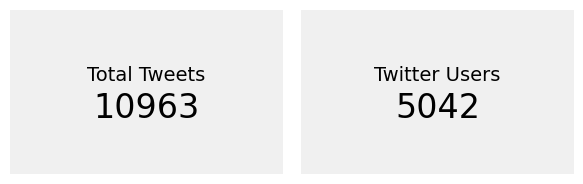

In [5]:
# Apply a Seaborn theme for consistent styling
sns.set_theme(style="white")

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(6, 2))  # adjust figsize as needed

for ax in axes:
    ax.axis('off')  # hide the axes for a clean card look
    # Add a background rectangle to simulate the card
    card_bg = plt.Rectangle((0, 0), 1, 1, transform=ax.transAxes, color="#f0f0f0")
    ax.add_patch(card_bg)

# First card
axes[0].text(0.5, 0.6, "Total Tweets", fontsize=14, ha="center", va="center", color="black")
axes[0].text(0.5, 0.4, f"{total_tweets}", fontsize=24, ha="center", va="center", color="black")

# Second card
axes[1].text(0.5, 0.6, "Twitter Users", fontsize=14, ha="center", va="center", color="black")
axes[1].text(0.5, 0.4, f"{user_count}", fontsize=24, ha="center", va="center", color="black")

# Save the figure as an image file (download it)
# plt.savefig("tweet_card_visual.png", dpi=300)

plt.tight_layout()
plt.show()


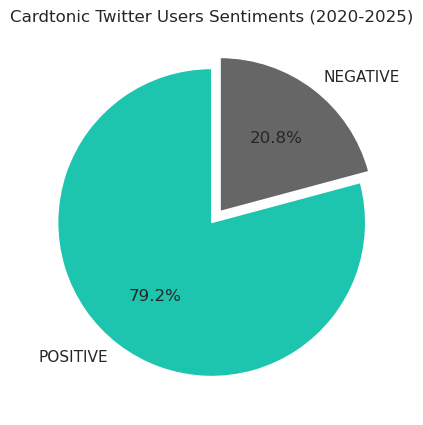

In [6]:
# Plotting a pie chart to show distribution of Sentiments
plt.figure(figsize=[7,5], facecolor='none')
plt.pie(tweets_df['sentiment'].value_counts(), labels=['POSITIVE', "NEGATIVE"], colors=['#1dc5af', '#666666'], startangle=90, explode= [0,0.09], autopct='%1.1f%%');
plt.title('Cardtonic Twitter Users Sentiments (2020-2025)');
plt.savefig("pie_chart.png", dpi=300)

In [7]:
negative_df = tweets_df[tweets_df['sentiment'] == 'negative']

**Observation**: Between 2020 and 2025, 53.9% of tweets about Cardtonic are neutral, 30.4% are positive, and 15.8% are negative.

In [8]:
negative_df[['sentiment', 'confidence','tweet', 'polarity']].head(10)

,sentiment,confidence,tweet,polarity
41,negative,0.935383,it is better you reply my dm before i send pro...,-1
42,negative,0.991780,you guys ripped me,-1
47,negative,0.917758,you guys should work on your app ona dey take ...,-1
49,negative,0.994270,theyre very slow in trading and payments,-1
51,negative,0.967638,i have tried doing it but i dont the how to do it,-1
62,negative,0.875928,dapsy latest ego foreign,-1
68,negative,0.997732,your customer service cant do shit about it th...,-1
88,negative,0.987363,cardbrother review for ig no good at all and ...,-1
90,negative,0.895516,years with cardtonic nothing like scam,-1
92,negative,0.995137,thieves have dumped them and uninstall their a...,-1


### Creating word cloud

In [12]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['u', 'na', 'know', 'one', 'go', 'make', 'see', 'dont', 'amp', 'im', 'cant']
tweets_df['cleaned_words'] = tweets_df['tweet'].astype(str).apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

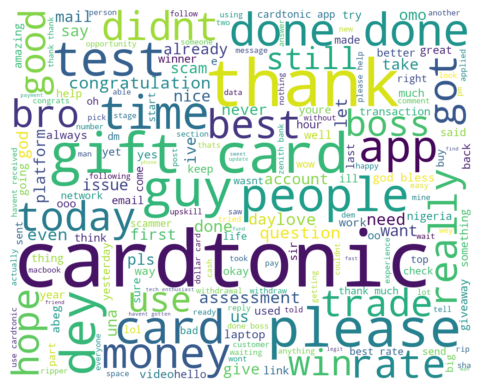

In [13]:
#Creating the text variable
text = " ".join(i for i in tweets_df.cleaned_words)

wc = WordCloud(width = 1000, height = 800, background_color = "white").generate(text)

#Remove axis and display the data as image
plt.axis("off")
plt.savefig("wordcloud.png", dpi=300)
plt.imshow(wc, interpolation = "bilinear")

**Observation**: The word cloud reveals the most frequent words in the tweets. "Cardtonic" is the subject matter, accompanied by other positive/neutral words such as thank, "gift card," money, people etc.

### Create Average Monthly Sentiment Analysis

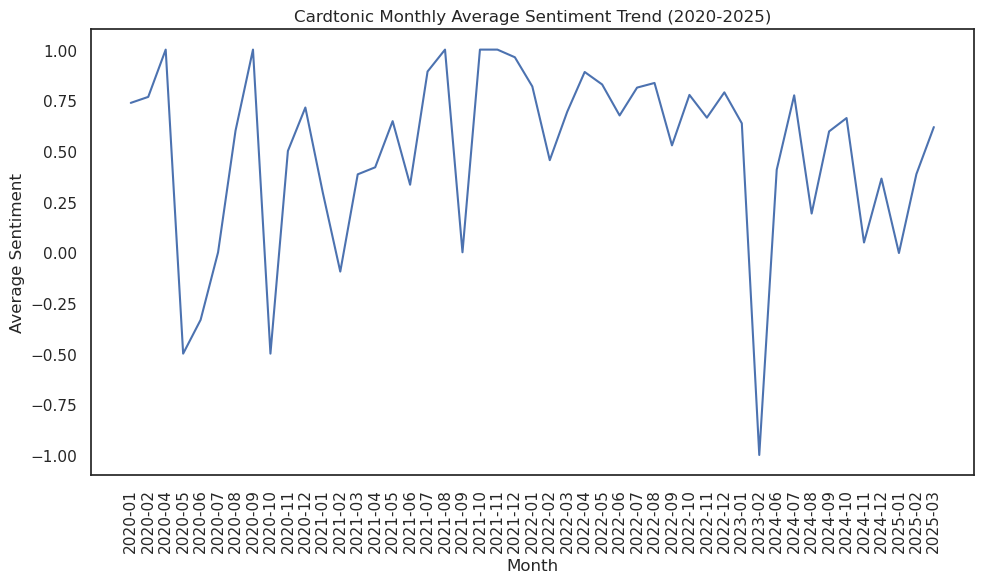

In [16]:
# Extract month-year and group by it

tweets_df["date"] = pd.to_datetime(tweets_df["date"])

# This creates a new column in 'YYYY-MM' format
tweets_df['month_year'] = tweets_df['date'].dt.to_period('M').astype(str)
# Group by month and compute the average sentiment for each month
monthly_sentiment = tweets_df.groupby('month_year')['polarity'].mean().reset_index()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the monthly trend using Seaborn
sns.lineplot(data=monthly_sentiment, x='month_year', y='polarity', ax=ax)
plt.title('Cardtonic Monthly Average Sentiment Trend (2020-2025)')
plt.xlabel('Month')
plt.ylabel('Average Sentiment')

plt.xticks(rotation=90)  # Rotate x labels for readability
plt.tight_layout()      
plt.savefig("month_sentiment_trend.png", dpi=300)
plt.show()

**Observation**: The chart displays monthly average sentiment trend since 2020-2025. The sentiment polarity ranges from -1 to 1 (where Negative=-1, Neutral=0 and Positive=1). November 2021 reached the highest positive sentiment, while January 2023 registered the most negative sentiment. Recent tweets show a moderate overall polarity.

/tmp/ipykernel_270299/4108587239.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="date", y="count", data=monthly_counts, palette="viridis")


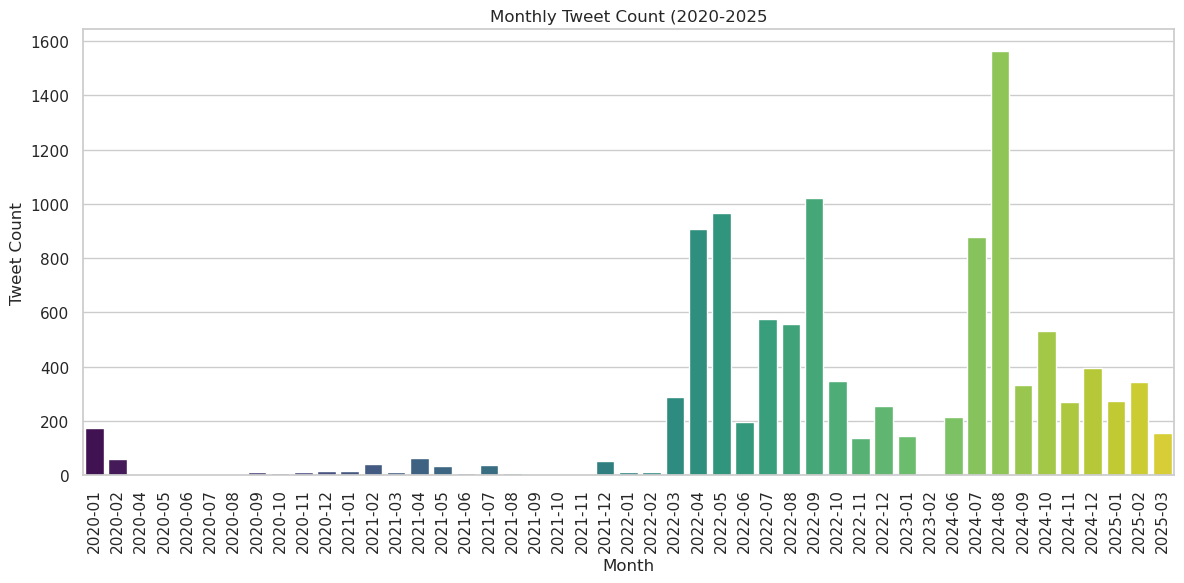

In [17]:
# Group by month using the dt.to_period accessor and count tweets
monthly_counts = tweets_df.groupby(tweets_df['date'].dt.to_period('M')).size().reset_index(name='count')

# Set up the seaborn style and figure size
sns.set(style="whitegrid")
plt.figure(figsize=(12,6))

# Create the barplot
sns.barplot(x="date", y="count", data=monthly_counts, palette="viridis")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.xlabel("Month")
plt.ylabel("Tweet Count")
plt.title("Monthly Tweet Count (2020-2025")

plt.tight_layout()

# Save the image
plt.savefig("monthly_tweet_count.png", dpi=300)

plt.show()

In [23]:
# Set the maximum column width to None (i.e., no truncation)
pd.set_option('display.max_colwidth', None)
tweets_df[tweets_df['month_year'] == '2023-02'][['sentiment', 'confidence','tweet', 'polarity']]

,sentiment,confidence,tweet,polarity
4966,negative,0.995753,what about the killing in delta state sapele everyday by day,-1
4967,negative,0.964612,i trade card with cardtonic yesterday but the money they sent never enter now telling i should wait till hours will the person that gives me work will understand this since yesterday now tell me to contact my bank are they not the one that s,-1


### The top issues customers face (e.g., transaction failures, limits, blocked cards)

In [193]:
negative_df = tweets_df[tweets_df['sentiment'] == 'negative']

In [194]:
# Set the max column width to None to display the full text
pd.set_option('display.max_colwidth', None)

negative_df[['sentiment','confidence','tweet']].head()

,sentiment,confidence,tweet
41,negative,0.935383,it is better you reply my dm before i send proof to verydarkman and get justice and nigeria will stop trading with you
42,negative,0.991780,you guys ripped me
47,negative,0.917758,you guys should work on your app ona dey take forever to pay and e no sharp
49,negative,0.994270,theyre very slow in trading and payments
51,negative,0.967638,i have tried doing it but i dont the how to do it


In [195]:
negative_df.shape

(2283, 18)

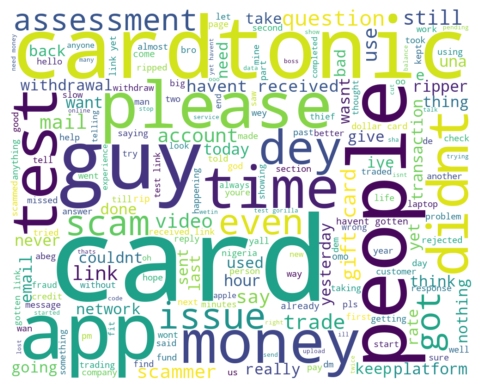

In [196]:
#Creating the text variable
text = " ".join(i for i in negative_df.cleaned_words)

wc = WordCloud(width = 1000, height = 800, background_color = "white").generate(text)

#Remove axis and display the data as image
plt.axis("off")
plt.savefig("negative_wordcloud", dpi=300)
plt.imshow(wc, interpolation = "bilinear")

**Observation**: A significant number of negative tweets highlight issues with the app, card, account, and timing. This suggests that the app needs a thorough evaluation and subsequent updates to enhance the user experience. Also, the sales and customer service teams must respond promptly to customer concerns. Negative remarks featuring words such as "scam," "scammer," or "bad" should be addressed immediately to restore customer confidence in Cardtonic.

In [197]:
negative_df.to_csv('/home/anelawrence/cardtonic_data/negative_tweets.csv', index=False)

### Cardtonic common positive themes

In [198]:
positive_df = tweets_df[tweets_df['sentiment'] == 'positive']

In [199]:
positive_df[['sentiment','confidence','tweet']].head()

,sentiment,confidence,tweet
0,positive,0.994399,let your face shine upon me
1,positive,0.547732,na me be number
2,positive,0.670869,leggooo
3,positive,0.725139,leggoooo
4,positive,0.552927,pick me as


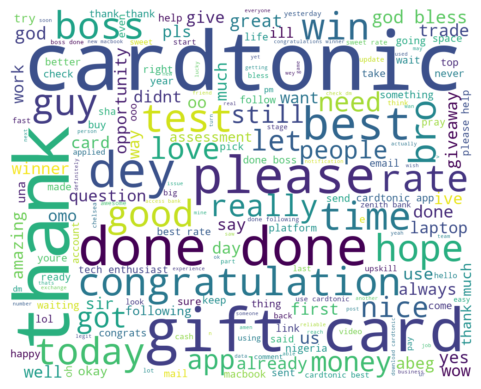

In [200]:
#Creating the text variable
text = " ".join(i for i in positive_df.cleaned_words)

wc = WordCloud(width = 1000, height = 800, background_color = "white").generate(text)

#Remove axis and display the data as image
plt.axis("off")
plt.savefig("positive_wordcloud.png", dpi=300)
plt.imshow(wc, interpolation = "bilinear")

**Observation:** Most of positive tweets made reference to the Appreciative words like thank, best, congratulations. This might be influenced by Customer reward programs,  excellent customer service, promotional giveaway, etc  

In [201]:
positive_df.shape

(8680, 18)

In [202]:
positive_df.to_csv('/home/anelawrence/cardtonic_data/positive_tweets.csv', index=False)

# 2025 Tweets Analysis

1. Add a new pie chart and remove Neutral sentiments
2. Increase the limit of the word count
3. Let’s have a time series analysis for mentions
4. Increase the word count for top issues users face
5. Filter out older dates and let’s see recent top issues for this year.
6. Same for positive tweets.

In [203]:
# Define the threshold date
threshold = pd.Timestamp('2025-01-01')

# Filter the DataFrame: keep rows with date >= threshold
tweets_df_25 = tweets_df[tweets_df['date'] >= threshold].copy()

tweets_df_25.shape

(777, 18)

In [204]:
# Save to a CSV file
tweets_df_25.to_csv("/home/anelawrence/cardtonic_data/2025_tweets_data.csv", index=False)

In [205]:
tweets_df_25 = pd.read_csv("/home/anelawrence/cardtonic_data/2025_tweets_data.csv")

In [206]:
total_tweets = tweets_df_25.shape[0]
total_tweets

777

In [207]:
user_count = tweets_df_25['author/userName'].nunique()
user_count

441

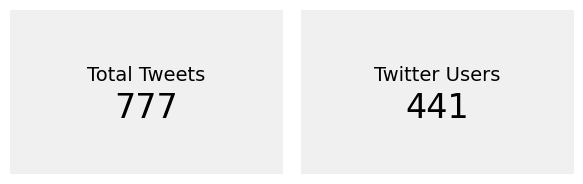

In [208]:
# Apply a Seaborn theme for consistent styling
sns.set_theme(style="white")

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(6, 2))  # adjust figsize as needed

for ax in axes:
    ax.axis('off')  # hide the axes for a clean card look
    # Add a background rectangle to simulate the card
    card_bg = plt.Rectangle((0, 0), 1, 1, transform=ax.transAxes, color="#f0f0f0")
    ax.add_patch(card_bg)

# First card
axes[0].text(0.5, 0.6, "Total Tweets", fontsize=14, ha="center", va="center", color="black")
axes[0].text(0.5, 0.4, f"{total_tweets}", fontsize=24, ha="center", va="center", color="black")

# Second card
axes[1].text(0.5, 0.6, "Twitter Users", fontsize=14, ha="center", va="center", color="black")
axes[1].text(0.5, 0.4, f"{user_count}", fontsize=24, ha="center", va="center", color="black")

# Save the figure as an image file
plt.savefig("tweet_card_visual_2025.png", dpi=300)

plt.tight_layout()
plt.show()


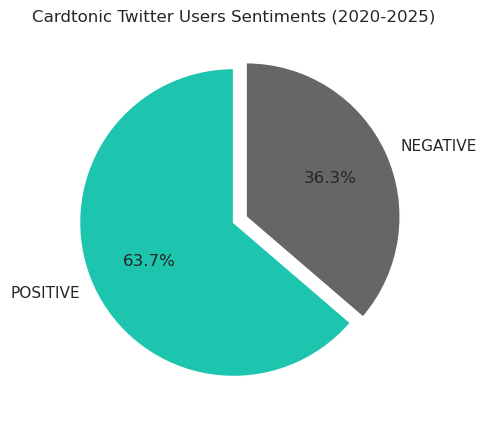

In [209]:
# Plotting a pie chart to show distribution of Sentiments
plt.figure(figsize=[7,5], facecolor='none')
plt.pie(tweets_df_25['sentiment'].value_counts(), labels=['POSITIVE', "NEGATIVE"], colors=['#1dc5af', '#666666'], startangle=90, explode= [0,0.09], autopct='%1.1f%%');
plt.title('Cardtonic Twitter Users Sentiments (2020-2025)');
plt.savefig("2025_pie_chart.png", dpi=300)

In [210]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['u', 'na', 'know', 'one', 'go', 'make', 'see', 'dont', 'amp', 'im', 'cant']
tweets_df_25['cleaned_words'] = tweets_df_25['tweet'].astype(str).apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

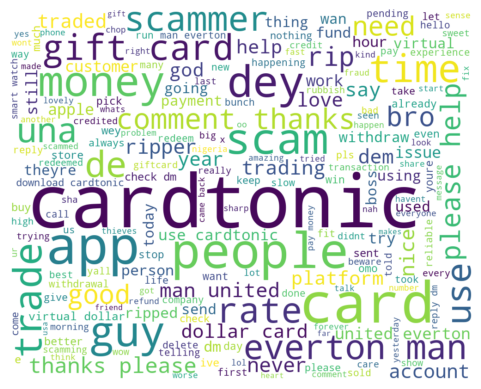

In [211]:
#Creating the text variable
text = " ".join(i for i in tweets_df_25.cleaned_words)

wc = WordCloud(width = 1000, height = 800, background_color = "white").generate(text)

#Remove axis and display the data as image
plt.axis("off")
plt.savefig("2025_wordcloud.png", dpi=300)
plt.imshow(wc, interpolation = "bilinear")

## Negative tweets 2025

In [212]:
negative_df_25 = tweets_df_25[tweets_df_25['sentiment'] == 'negative']

In [213]:
negative_df_25.shape

(282, 18)

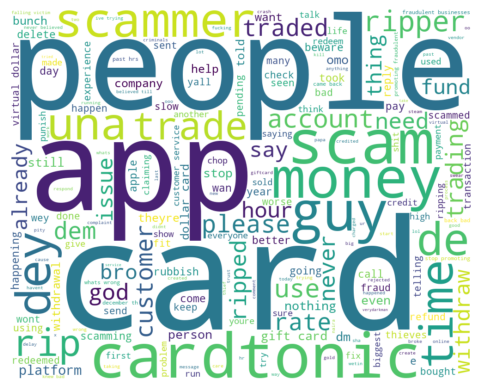

In [214]:
#Creating the text variable
text = " ".join(i for i in negative_df_25.cleaned_words)

wc = WordCloud(width = 1000, height = 800, background_color = "white").generate(text)

#Remove axis and display the data as image
plt.axis("off")
plt.savefig("2025_negative_wc.png", dpi=300)
plt.imshow(wc, interpolation = "bilinear")

In [215]:
positive_df_25 = tweets_df_25[tweets_df_25['sentiment'] == 'positive']

In [216]:
positive_df_25.shape

(495, 18)

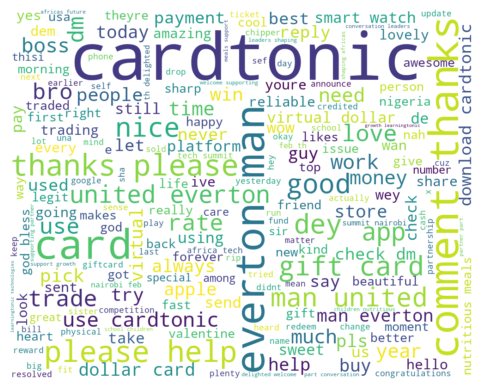

In [218]:
#Creating the text variable
text = " ".join(i for i in positive_df_25.cleaned_words)

wc = WordCloud(width = 1000, height = 800, background_color = "white").generate(text)

#Remove axis and display the data as image
plt.axis("off")
plt.savefig("2025_positive_wc.png", dpi=300)
plt.imshow(wc, interpolation = "bilinear")